In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import simpy
from LEOEnvironmentRL import initialize, load_route_from_csv  # Use RL version
import pandas as pd
import os
from stable_baselines3 import DQN
from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker
import torch
import random

# %% 
import sb3_contrib
from HandoverEnvironment import LEOEnv as LEOEnvPPO 
from HandoverEnvironment import mask_fn, predict_valid_action
from HandoverEnvironment_DQN import LEOEnv as LEOEnvDQN
from HandoverEnvironment_DQN import predict_valid_action as predict_valid_action_dqn
from LEOEnvironment import LEOEnv as LEOEnvBase

['ARS', 'CrossQ', 'MaskablePPO', 'QRDQN', 'RecurrentPPO', 'TQC', 'TRPO', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'ars', 'common', 'crossq', 'file_handler', 'os', 'ppo_mask', 'ppo_recurrent', 'qrdqn', 'tqc', 'trpo', 'version_file']


In [2]:
# Create PPO environment
inputParams = pd.read_csv("input.csv")
constellation_name = inputParams['Constellation'][0]
route, route_duration = load_route_from_csv('route.csv', skip_rows=3)
ppo_env = LEOEnvPPO(constellation_name, route)
ppo_env = ActionMasker(ppo_env, mask_fn)
# Evaluation with debugging
obs, info = ppo_env.reset()
print(f"Initial mask sum: {np.sum(ppo_env.action_mask) if hasattr(ppo_env, 'action_mask') else 'No mask attr'}")

Loading flight route from csv
UTF-8 decoding error: 'utf-8' codec can't decode byte 0xa0 in position 165: invalid start byte. Trying latin1 encoding.
[{'Time (EDT)': 'Tue 10:48:57 AM', 'Latitude': '29.9569', 'Longitude': '-95.3369', 'Course': '? 133°', 'kts': '159', 'mph': '183', 'feet': '1,075', 'Rate': '1,922\xa0Climbing', 'Reporting Facility': '\xa0FlightAware ADS-B\xa0(KIAH)'}, {'Time (EDT)': 'Tue 10:49:13 AM', 'Latitude': '29.9482', 'Longitude': '-95.3254', 'Course': '? 131°', 'kts': '174', 'mph': '200', 'feet': '1,475', 'Rate': '1,313\xa0Climbing', 'Reporting Facility': '\xa0FlightAware ADS-B\xa0(KIAH)'}, {'Time (EDT)': 'Tue 10:49:29 AM', 'Latitude': '29.9394', 'Longitude': '-95.3129', 'Course': '? 128°', 'kts': '194', 'mph': '223', 'feet': '1,775', 'Rate': '984\xa0Climbing', 'Reporting Facility': '\xa0FlightAware ADS-B\xa0(KAXH)'}, {'Time (EDT)': 'Tue 10:49:45 AM', 'Latitude': '29.9303', 'Longitude': '-95.2989', 'Course': '? 126°', 'kts': '218', 'mph': '251', 'feet': '2,000', 'R

In [3]:
# Load PPO Agent 
ppo_agent = MaskablePPO("MlpPolicy", ppo_env, verbose=1)
ppo_agent.load("handover_ppo_agent")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [4]:
# Create DQN Environment
inputParams = pd.read_csv("input.csv")
constellation_name = inputParams['Constellation'][0]
route, route_duration = load_route_from_csv('route.csv', skip_rows=3)
dqn_env = LEOEnvDQN(constellation_name, route)
dqn_env = ActionMasker(dqn_env, mask_fn)
# Evaluation with debugging
obs, info = dqn_env.reset()
print(f"Initial mask sum: {np.sum(dqn_env.action_mask) if hasattr(dqn_env, 'action_mask') else 'No mask attr'}")


Loading flight route from csv
UTF-8 decoding error: 'utf-8' codec can't decode byte 0xa0 in position 165: invalid start byte. Trying latin1 encoding.
[{'Time (EDT)': 'Tue 10:48:57 AM', 'Latitude': '29.9569', 'Longitude': '-95.3369', 'Course': '? 133°', 'kts': '159', 'mph': '183', 'feet': '1,075', 'Rate': '1,922\xa0Climbing', 'Reporting Facility': '\xa0FlightAware ADS-B\xa0(KIAH)'}, {'Time (EDT)': 'Tue 10:49:13 AM', 'Latitude': '29.9482', 'Longitude': '-95.3254', 'Course': '? 131°', 'kts': '174', 'mph': '200', 'feet': '1,475', 'Rate': '1,313\xa0Climbing', 'Reporting Facility': '\xa0FlightAware ADS-B\xa0(KIAH)'}, {'Time (EDT)': 'Tue 10:49:29 AM', 'Latitude': '29.9394', 'Longitude': '-95.3129', 'Course': '? 128°', 'kts': '194', 'mph': '223', 'feet': '1,775', 'Rate': '984\xa0Climbing', 'Reporting Facility': '\xa0FlightAware ADS-B\xa0(KAXH)'}, {'Time (EDT)': 'Tue 10:49:45 AM', 'Latitude': '29.9303', 'Longitude': '-95.2989', 'Course': '? 126°', 'kts': '218', 'mph': '251', 'feet': '2,000', 'R

In [5]:
# Load DQN Agent 
dqn_agent = DQN("MlpPolicy", dqn_env, verbose=1, buffer_size=100) 
dqn_agent.load("handover_dqn_agent")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [6]:
# Initalize baseline environment
inputParams = pd.read_csv("input.csv")
constellation_name = inputParams['Constellation'][0]
route, route_duration = load_route_from_csv('route.csv', skip_rows=3)
base_env = LEOEnvBase(constellation_name, route)

# Evaluation with debugging
obs, info = base_env.reset()

Loading flight route from csv
UTF-8 decoding error: 'utf-8' codec can't decode byte 0xa0 in position 165: invalid start byte. Trying latin1 encoding.
[{'Time (EDT)': 'Tue 10:48:57 AM', 'Latitude': '29.9569', 'Longitude': '-95.3369', 'Course': '? 133°', 'kts': '159', 'mph': '183', 'feet': '1,075', 'Rate': '1,922\xa0Climbing', 'Reporting Facility': '\xa0FlightAware ADS-B\xa0(KIAH)'}, {'Time (EDT)': 'Tue 10:49:13 AM', 'Latitude': '29.9482', 'Longitude': '-95.3254', 'Course': '? 131°', 'kts': '174', 'mph': '200', 'feet': '1,475', 'Rate': '1,313\xa0Climbing', 'Reporting Facility': '\xa0FlightAware ADS-B\xa0(KIAH)'}, {'Time (EDT)': 'Tue 10:49:29 AM', 'Latitude': '29.9394', 'Longitude': '-95.3129', 'Course': '? 128°', 'kts': '194', 'mph': '223', 'feet': '1,775', 'Rate': '984\xa0Climbing', 'Reporting Facility': '\xa0FlightAware ADS-B\xa0(KAXH)'}, {'Time (EDT)': 'Tue 10:49:45 AM', 'Latitude': '29.9303', 'Longitude': '-95.2989', 'Course': '? 126°', 'kts': '218', 'mph': '251', 'feet': '2,000', 'R

In [7]:
# set training to false to enable saving plots 
base_env.earth.Training = False
dqn_env.env.earth.Training = False
ppo_env.env.earth.Training = False

done_ppo = False
done_dqn = False
done_base = False
step_count = 0

obs_ppo, info_ppo = ppo_env.reset()
obs_dqn, info_dqn = dqn_env.reset()
obs_base, info_base = base_env.reset()

obs_ppo_list = []
obs_dqn_list = []
obs_base_list = []

while not (done_ppo or done_dqn or done_base):
    print(f"\n--- Step {step_count} ---")
    
    # PPO Agent Step
    mask_ppo = ppo_env.env._get_action_mask()
    print(f"PPO Valid actions: {np.sum(mask_ppo)}")
    action_ppo = predict_valid_action(ppo_agent, obs_ppo, mask_ppo)
    print(f"PPO Action: {action_ppo}, Valid: {mask_ppo[action_ppo]}")
    obs_ppo, reward_ppo, done_ppo, truncated_ppo, info_ppo = ppo_env.env.step(action_ppo)
    obs_ppo_list.append(obs_ppo)

    # DQN Agent Step
    mask_dqn = dqn_env.env._get_action_mask()
    print(f"DQN Valid actions: {np.sum(mask_dqn)}")
    action_dqn = predict_valid_action_dqn(dqn_agent, obs_dqn, mask_dqn)
    print(f"DQN Action: {action_dqn}, Valid: {mask_dqn[action_dqn]}")
    obs_dqn, reward_dqn, done_dqn, truncated_dqn, info_dqn = dqn_env.step(action_dqn)
    obs_dqn_list.append(obs_dqn)

    # Baseline Environment Step
    obs_base, reward_base, done_base, truncated_base, info_base = base_env.step()
    obs_base_list.append(obs_base)
    
    step_count += 1

Aircraft A-380 initialized at (29.96, -95.34)
Using OneWeb constellation design
Initialized Earth
total divisions in x = 1920
 total divisions in y = 906
 total cells = 1739520
 window of operation (longitudes) = (0, 1920)
 window of operation (latitudes) = (0, 906)

candidates found: 2
Aircraft A-380 initialized at (29.96, -95.34)
Using OneWeb constellation design
Initialized Earth
total divisions in x = 1920
 total divisions in y = 906
 total cells = 1739520
 window of operation (longitudes) = (0, 1920)
 window of operation (latitudes) = (0, 906)

candidates found: 2
Aircraft A-380 initialized at (29.96, -95.34)
Using OneWeb constellation design
Initialized Earth
total divisions in x = 1920
 total divisions in y = 906
 total cells = 1739520
 window of operation (longitudes) = (0, 1920)
 window of operation (latitudes) = (0, 906)

--- Step 0 ---
PPO Valid actions: 2
PPO Action: 5693, Valid: True
Action received: 5693
10368
Aircraft A-380 HANDOVER from None to beam 9_31_beam_14
route i

In [8]:
obs_base_list = np.array(obs_base_list)
obs_dqn_list = np.array(obs_dqn_list)    
obs_ppo_list = np.array(obs_ppo_list)

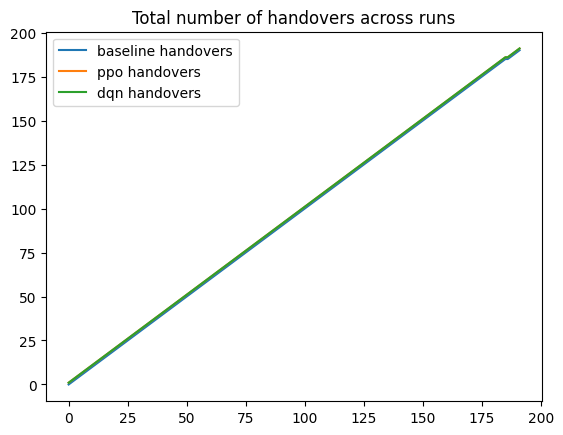

In [13]:
import matplotlib.pyplot as plt
plt.plot(obs_base_list[:, 6], label = 'baseline handovers')
plt.plot(obs_ppo_list[:, 6], label = 'ppo handovers')
plt.plot(obs_dqn_list[:, 6], label = 'dqn handovers')
plt.legend()
plt.title('Total number of handovers across runs')
plt.show()

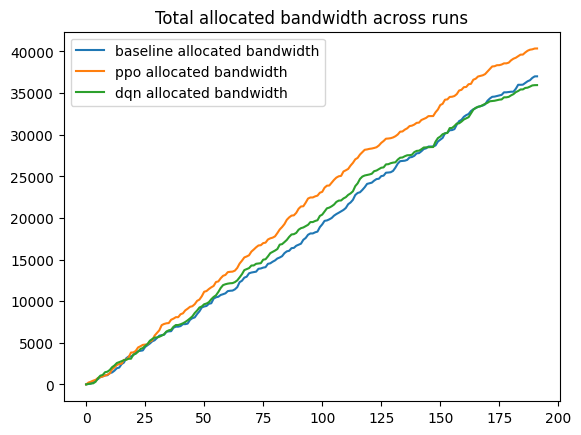

In [10]:
plt.plot(obs_base_list[:, 7], label = 'baseline allocated bandwidth')
plt.plot(obs_ppo_list[:, 7], label = 'ppo allocated bandwidth')
plt.plot(obs_dqn_list[:, 7], label = 'dqn allocated bandwidth')
plt.legend()
plt.title('Total allocated bandwidth across runs')
plt.show()

In [11]:
# Get average allocation to demand across runs 
avg_allocated_to_demand_base = []
avg_allocated_to_demand_ppo = []
avg_allocated_to_demand_dqn = []

for i in range(len(obs_base_list)): 
    avg_allocated_to_demand_base.append(np.mean(obs_base_list[:i, 8]))
    avg_allocated_to_demand_ppo.append(np.mean(obs_ppo_list[:i, 8]))
    avg_allocated_to_demand_dqn.append(np.mean(obs_dqn_list[:i, 8]))

c:\Users\hmukhtar\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\hmukhtar\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


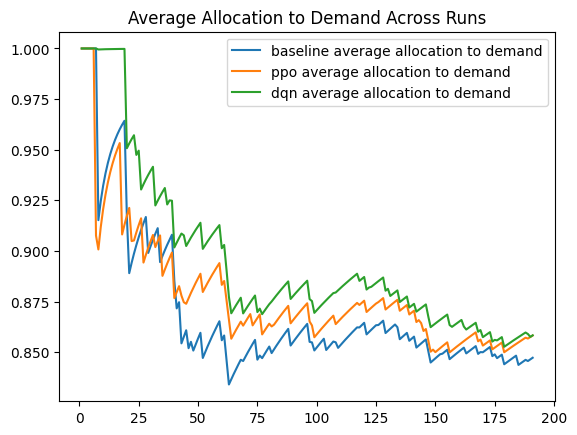

In [12]:
plt.plot(avg_allocated_to_demand_base, label = 'baseline average allocation to demand')
plt.plot(avg_allocated_to_demand_ppo, label = 'ppo average allocation to demand')
plt.plot(avg_allocated_to_demand_dqn, label = 'dqn average allocation to demand')
plt.legend()
plt.title('Average Allocation to Demand Across Runs')
plt.show()

In [14]:
# Get average allocation to demand across runs 
allocated_to_demand_base = []
allocated_to_demand_ppo = []
allocated_to_demand_dqn = []

for i in range(len(obs_base_list)): 
    allocated_to_demand_base.append(obs_base_list[i, 8])
    allocated_to_demand_ppo.append(obs_ppo_list[i, 8])
    allocated_to_demand_dqn.append(obs_dqn_list[i, 8])

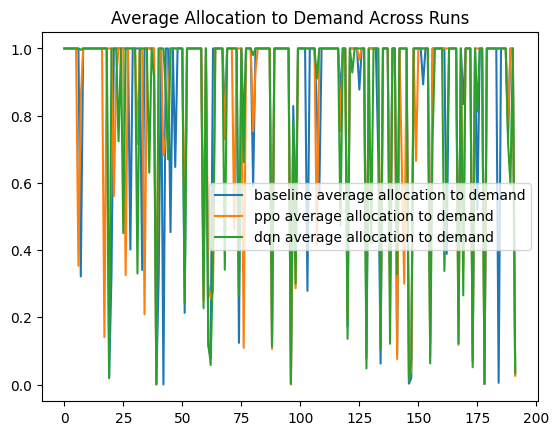

In [15]:
plt.plot(allocated_to_demand_base, label = 'baseline average allocation to demand')
plt.plot(allocated_to_demand_ppo, label = 'ppo average allocation to demand')
plt.plot(allocated_to_demand_dqn, label = 'dqn average allocation to demand')
plt.legend()
plt.title('Average Allocation to Demand Across Runs')
plt.show()